In [1]:
import sys
sys.path.insert(0,'..')
sys.path.insert(0,'../../WobbleSim')
import simulacra.dataset
import astropy
import astropy.units as u 
import astropy.coordinates as coord
import astropy.time as at
import astropy.constants as const
import numpy as np
import itertools

from IPython.display import Video

import jabble.dataset
import jabble.loss
import jabble.model
import os

import matplotlib.pyplot as plt
from matplotlib import cm

<h1>32 - Take data from MANY straight flying star</h1>

In [2]:
# import cv2

In [3]:
from datetime import datetime
import os
date = datetime.today().strftime('%Y-%m-%d')
outdir = os.path.join('/scratch/mdd423/wobble_jax/out/',date)
os.makedirs(outdir,exist_ok=True)

In [4]:
import glob
files = glob.glob('/scratch/mdd423/simulacra/out/2022-04-19/data_*')
# import os
# mypath = '/scratch/mdd423/simulacra/out/2022-03-07/'
# files = [os.path.join(mypath, f) for f in os.listdir(mypath) if os.path.isfile(os.path.join(mypath, f)) and "8.3e+03" in f]

In [5]:
files

['/scratch/mdd423/simulacra/out/2022-04-19/data_e30_R130000.0_a10.0_p30.0_l7.0e+037.1e+03_snr250.0.h5',
 '/scratch/mdd423/simulacra/out/2022-04-19/data_e30_R130000.0_a10.0_p30.0_l7.0e+037.1e+03_snr50.0.h5',
 '/scratch/mdd423/simulacra/out/2022-04-19/data_e30_R130000.0_a10.0_p30.0_l7.0e+037.1e+03_snr300.0.h5',
 '/scratch/mdd423/simulacra/out/2022-04-19/data_e30_R130000.0_a10.0_p30.0_l7.0e+037.1e+03_snr200.0.h5',
 '/scratch/mdd423/simulacra/out/2022-04-19/data_e30_R130000.0_a10.0_p30.0_l7.0e+037.1e+03_snr150.0.h5',
 '/scratch/mdd423/simulacra/out/2022-04-19/data_e30_R130000.0_a10.0_p30.0_l7.0e+037.1e+03_snr100.0.h5']

In [6]:
import scipy.ndimage
def normalize(y,sigma):
    y_low = scipy.ndimage.gaussian_filter(y,sigma)
    return y_low

In [7]:
datasets = []
h5_data = []
snrs = []
for file in files:
    data    = simulacra.dataset.from_h5(file)
    h5_data.append(data)
    epoches = data['data']['flux'].shape[0]

    wave = np.repeat(np.array(data['data']['wave'])[np.newaxis,:],epoches,axis=0) * u.Angstrom
    flux = np.array(data['data']['flux'])
    ferr = np.array(data['data']['ferr'])

    masks = np.array(data['data']['mask'],dtype=bool)
    masks = np.logical_or(np.isnan(ferr), masks)
    masks = np.logical_or(np.isnan(flux), masks)
    masks = np.logical_or(flux <= 0, masks)

    sigma = 400
    dataset = jabble.dataset.Dataset.from_flux(wave,flux,ferr,masks,normalize,nargs=[sigma])
    dataset.set_mask(0.0,10.0)
    
    datasets.append(dataset)

    obs_times = data['data']['obs_times']
    times = at.Time(obs_times)

    loc    = data['parameters']['detector']['loc']
    target = data['parameters']['star']['target']
    resolution = float(data['parameters']['detector']['_resolution'][()])

    bc = target.radial_velocity_correction(obstime=times[-1],location=loc).to(u.km/u.s)
    rv = data['data']['rvs'].to(u.km/u.s)
    snr = np.mean(data['data']['snr_readout'][~np.isnan(data['data']['snr_readout'])])
    snrs.append(snr)
    print(snr)

<HDF5 dataset "obs_times": shape (30,), type "|O">
252.1516725536826
<HDF5 dataset "obs_times": shape (30,), type "|O">
50.42867747101013
<HDF5 dataset "obs_times": shape (30,), type "|O">
302.5799087328227
<HDF5 dataset "obs_times": shape (30,), type "|O">
201.71960040464376
<HDF5 dataset "obs_times": shape (30,), type "|O">
151.28973039466257
<HDF5 dataset "obs_times": shape (30,), type "|O">
100.85929130831641


<h2>Load Data</h2>
Load in the datasets and normalize it using a gaussian filter. And take a look at slices of each dataset. Each dataset read in has a different average SNR across all epoches. We will fit a model to each dataset and compare the accuracy of the radial velocity as function of this SNR.

In [8]:
len(h5_data)

6

In [9]:
def normal_flux(y,sigma=100):
    y_low = scipy.ndimage.gaussian_filter(y,sigma)
    return y/y_low

<h2>Mask ends</h2>
Mask off the ends of the dataset with a padding larger than any possible velocity shift.

In [10]:
max_vel = 600 * u.km/u.s
padding = jabble.dataset.shifts(max_vel)

for dataset in datasets:
    x_min = np.min(dataset.xs)
    x_max = np.max(dataset.xs)
    dataset.mask[dataset.xs < x_min + padding] = 1
    dataset.mask[dataset.xs > x_max - padding] = 1
    dataset.set_mask(0.0,10.0)

KeyError: 'random'

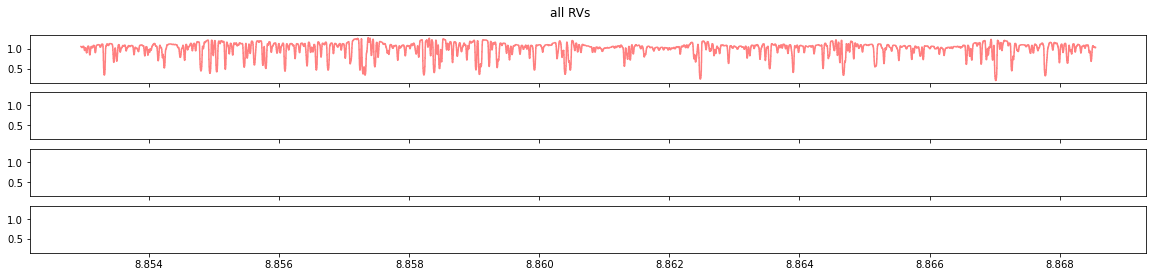

In [11]:
plt_inds = 4
xpmin = np.log(7060)
xpmax = np.log(7080)
fig, axes = plt.subplots(plt_inds,figsize=(20,4),sharex=True,sharey=True)

fig.suptitle('all RVs')
dataset_i = 0
for j in range(plt_inds):        
    axes[j].step(np.log(h5_data[dataset_i]['theory']['interpolated']['total']['wave'].to(u.Angstrom).value),(normal_flux(h5_data[dataset_i]['theory']['interpolated']['star']['flux'][j,:])),'r',where='mid',alpha=0.5)
    axes[j].step(np.log(h5_data[dataset_i]['theory']['interpolated']['total']['wave'].to(u.Angstrom).value),(h5_data[dataset_i]['theory']['interpolated']['random']['flux'][j,:]),'b',where='mid',alpha=0.5)
    axes[j].step(np.log(h5_data[dataset_i]['data']['wave'].to(u.Angstrom).value),(normal_flux(h5_data[dataset_i]['data']['flux'][j,:])),'k',where='mid')

    axes[j].set_xlim(xpmin,xpmax)
    axes[j].set_ylim(0.0,1.2)
plt.show() 

In [ ]:
plt_i = 2
xpmin = np.log(7160)
xpmax = np.log(7180)
fig, axes = plt.subplots(len(datasets),figsize=(20,4),sharex=True,sharey=True)

fig.suptitle('all SNR')
for i in range(len(datasets)):       
    axes[i].step(np.log(h5_data[i]['theory']['interpolated']['total']['wave'].to(u.Angstrom).value),(normal_flux(h5_data[i]['theory']['interpolated']['star']['flux'][plt_i,:])),'r',where='mid',alpha=0.5)
    axes[i].step(np.log(h5_data[i]['theory']['interpolated']['total']['wave'].to(u.Angstrom).value),(h5_data[i]['theory']['interpolated']['random']['flux'][plt_i,:]),'b',where='mid',alpha=0.5)
    axes[i].step(np.log(h5_data[i]['data']['wave'].to(u.Angstrom).value),(normal_flux(h5_data[i]['data']['flux'][plt_i,:])),'k',where='mid')

    axes[i].set_xlim(xpmin,xpmax)
    axes[i].set_ylim(0.0,1.2)
plt.show()

<h2>Definitions</h2>
Define our loss function, Chi Square, Models, and Initial Values.

In [12]:
loss = jabble.loss.ChiSquare()

In [13]:
vel_padding = 4 * u.km/u.s
x_grid = jabble.model.create_x_grid(dataset.xs,vel_padding,2*resolution)#step=jabble.dataset.shifts(const.c.to(u.km/u.s)/resolution))

In [14]:
def train_cycle(model,data,loss,fit1_inds):
    model.fix()
    for ind in fit1_inds:
        model.fit(*ind)
    res1 = model.optimize(loss,data,options={'iprint':1,'ftol':1e-23,'maxls':512,'eps':1e-14,'maxiter':256},save_history=True,save_loss=True)
    model.fix()
    return model

<h2>Round 1</h2>
Fit the flux control points to the data using the train cycle described!

<h2>Round 2</h2>
now fitting both the flux control points and red shifts!

In [15]:
class 

SyntaxError: invalid syntax (3830843451.py, line 1)

In [16]:
ind1 = [[1]]
ind2 = [[0],[1]]

final_vels = np.zeros((len(datasets),epoches)) * u.km/u.s

init_vels = [np.linspace(-300 - val,300 + val,epoches) * u.km/u.s for val in [0,1,2,3]]
# init_vels = rv
init_shifts = [jabble.dataset.shifts(val) for val in init_vels]

models = [[jabble.model.CompositeModel([jabble.model.ShiftingModel(np.array(val)),jabble.model.JaxLinear(x_grid)]) for data in datasets] for val in init_shifts]
# for i in range(len(models)):
#     if i > 0:
#         print(id(models[i][0].p) == id(models[i-1][0].p))

for i in range(len(datasets)):
    for j in range(len(init_vels)):
        models[j][i].display()
        models[j][i] = train_cycle(models[j][i],datasets[i],loss,ind1)
#         models[i][j].display()
        models[j][i] = train_cycle(models[j][i],datasets[i],loss,ind2)

        filename = 'jab_model_snr_{}.model'.format(snrs[i])
#         jabble.model.save(os.path.join(outdir,filename),models[i])

#         final_vels[i,:] = jabble.dataset.velocities(models[i][j][0].p)

2022-06-06 12:03:53.386841: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64:/.singularity.d/libs
2022-06-06 12:03:53.386873: W external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)


-CompositeModel----------------------------------------------------0
  0-ShiftingModel--------------------------------------------------0
  1-JaxLinear------------------------------------------------------0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3695     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.67662D+08    |proj g|=  2.85215D+06


 This problem is unconstrained.



At iterate    1    f=  2.22837D+08    |proj g|=  2.67908D+06

At iterate    2    f=  4.98776D+07    |proj g|=  1.07432D+06

At iterate    3    f=  4.30798D+07    |proj g|=  7.38289D+05

At iterate    4    f=  3.96036D+07    |proj g|=  4.67740D+05

At iterate    5    f=  3.90371D+07    |proj g|=  5.14380D+05

At iterate    6    f=  3.84520D+07    |proj g|=  2.74482D+05

At iterate    7    f=  3.81482D+07    |proj g|=  1.92641D+05

At iterate    8    f=  3.79355D+07    |proj g|=  1.24564D+05

At iterate    9    f=  3.77482D+07    |proj g|=  9.44999D+04

At iterate   10    f=  3.76846D+07    |proj g|=  1.16348D+05

At iterate   11    f=  3.76242D+07    |proj g|=  9.59679D+04

At iterate   12    f=  3.75910D+07    |proj g|=  7.80050D+04

At iterate   13    f=  3.75725D+07    |proj g|=  1.03559D+05

At iterate   14    f=  3.75576D+07    |proj g|=  3.25082D+04

At iterate   15    f=  3.75541D+07    |proj g|=  2.20244D+04

At iterate   16    f=  3.75508D+07    |proj g|=  1.93389D+04

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3725     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.79089D+07    |proj g|=  5.88472D+11

At iterate    1    f=  1.23485D+07    |proj g|=  1.46055D+11

At iterate    2    f=  1.14590D+07    |proj g|=  5.43308D+10

At iterate    3    f=  1.14316D+07    |proj g|=  4.96867D+10

At iterate    4    f=  1.14215D+07    |proj g|=  4.52608D+10

At iterate    5    f=  1.14215D+07    |proj g|=  4.52608D+10

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 3725      5     35      1     0     0   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3695     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.67662D+08    |proj g|=  2.86939D+06

At iterate    1    f=  2.21310D+08    |proj g|=  2.70362D+06

At iterate    2    f=  3.23041D+07    |proj g|=  1.15198D+06

At iterate    3    f=  2.46656D+07    |proj g|=  7.34710D+05

At iterate    4    f=  2.09818D+07    |proj g|=  4.68004D+05

At iterate    5    f=  2.03649D+07    |proj g|=  4.92217D+05

At iterate    6    f=  1.97804D+07    |proj g|=  2.86142D+05

At iterate    7    f=  1.94613D+07    |proj g|=  2.04328D+05

At iterate    8    f=  1.92278D+07    |proj g|=  1.22181D+05

At iterate    9    f=  1.90348D+07    |proj g|=  9.14713D+04

At iterate   10    f=  1.89736D+07    |proj g|=  1.35747D+05

At iterate   11    f=  1.89161D+07    |proj g|=  9.20224D+04

At iterate   12    f=  1.88793D+07    |proj g|=  7.69794D+04

At iterate   13    f=  1.8


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3725     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.85404D+07    |proj g|=  4.63996D+11


 This problem is unconstrained.



At iterate    1    f=  4.89619D+06    |proj g|=  1.19058D+11

At iterate    2    f=  4.74597D+06    |proj g|=  5.88975D+10

At iterate    3    f=  4.70822D+06    |proj g|=  6.44952D+10

At iterate    4    f=  4.70088D+06    |proj g|=  6.44952D+10

At iterate    5    f=  4.70088D+06    |proj g|=  6.44952D+10

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 3725      5     39      1     0     0   6.450D+10   4.701D+06
  F =   4700879.5000000000     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
-CompositeModel----------------------------------------------------0
  0-ShiftingModel---------------------------


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3695     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.67662D+08    |proj g|=  2.88274D+06


 This problem is unconstrained.



At iterate    1    f=  2.20257D+08    |proj g|=  2.72708D+06

At iterate    2    f=  1.98187D+07    |proj g|=  1.18888D+06

At iterate    3    f=  1.15921D+07    |proj g|=  7.30208D+05

At iterate    4    f=  7.75456D+06    |proj g|=  4.78889D+05

At iterate    5    f=  7.08955D+06    |proj g|=  5.60915D+05

At iterate    6    f=  6.50697D+06    |proj g|=  2.97014D+05

At iterate    7    f=  6.17976D+06    |proj g|=  2.17380D+05

At iterate    8    f=  5.93418D+06    |proj g|=  1.18002D+05

At iterate    9    f=  5.73631D+06    |proj g|=  9.27373D+04

At iterate   10    f=  5.67694D+06    |proj g|=  1.21626D+05

At iterate   11    f=  5.62114D+06    |proj g|=  8.67656D+04

At iterate   12    f=  5.58181D+06    |proj g|=  7.54829D+04

At iterate   13    f=  5.55810D+06    |proj g|=  9.31491D+04

At iterate   14    f=  5.54260D+06    |proj g|=  3.72905D+04

At iterate   15    f=  5.53788D+06    |proj g|=  2.54430D+04

At iterate   16    f=  5.53411D+06    |proj g|=  2.13410D+04

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3725     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.69478D+06    |proj g|=  3.01621D+11

At iterate    1    f=  1.71015D+06    |proj g|=  1.05893D+11

At iterate    2    f=  1.66699D+06    |proj g|=  8.17633D+10

At iterate    3    f=  1.51330D+06    |proj g|=  4.54110D+10

At iterate    4    f=  1.51330D+06    |proj g|=  4.54110D+10

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 3725      4     35      1     0     0   4.541D+10   1.513D+06
  F =   1513297.5000000000     

CONVERG


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3695     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.67662D+08    |proj g|=  2.90206D+06


 This problem is unconstrained.



At iterate    1    f=  2.19876D+08    |proj g|=  2.74939D+06

At iterate    2    f=  1.52448D+07    |proj g|=  1.20059D+06

At iterate    3    f=  6.81867D+06    |proj g|=  7.22171D+05

At iterate    4    f=  2.92206D+06    |proj g|=  4.70441D+05

At iterate    5    f=  2.23766D+06    |proj g|=  5.37948D+05

At iterate    6    f=  1.65236D+06    |proj g|=  2.98643D+05

At iterate    7    f=  1.31913D+06    |proj g|=  2.18483D+05

At iterate    8    f=  1.06898D+06    |proj g|=  1.17935D+05

At iterate    9    f=  8.67931D+05    |proj g|=  9.25248D+04

At iterate   10    f=  8.08937D+05    |proj g|=  1.11103D+05

At iterate   11    f=  7.53676D+05    |proj g|=  8.53323D+04

At iterate   12    f=  7.12724D+05    |proj g|=  7.63728D+04

At iterate   13    f=  6.87300D+05    |proj g|=  9.36428D+04

At iterate   14    f=  6.71435D+05    |proj g|=  3.95656D+04

At iterate   15    f=  6.66157D+05    |proj g|=  2.63440D+04

At iterate   16    f=  6.62252D+05    |proj g|=  2.09184D+04

At iter

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3725     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.79209D+05    |proj g|=  4.95661D+10



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate    1    f=  7.79209D+05    |proj g|=  4.95661D+10

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 3725      1     36      1     0     0   4.957D+10   7.792D+05
  F =   779208.56250000000     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
-CompositeModel----------------------------------------------------0
  0-ShiftingModel--------------------------------------------------0
  1-JaxLinear------------------------------------------------------0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3695     M =           10

At X0         0 variables are exactly a

 This problem is unconstrained.



At iterate    1    f=  9.06681D+06    |proj g|=  1.07034D+05

At iterate    2    f=  2.14602D+06    |proj g|=  4.30632D+04

At iterate    3    f=  1.87355D+06    |proj g|=  2.95088D+04

At iterate    4    f=  1.73433D+06    |proj g|=  1.85875D+04

At iterate    5    f=  1.71190D+06    |proj g|=  2.09642D+04

At iterate    6    f=  1.68844D+06    |proj g|=  1.08059D+04

At iterate    7    f=  1.67637D+06    |proj g|=  7.54214D+03

At iterate    8    f=  1.66785D+06    |proj g|=  4.94729D+03

At iterate    9    f=  1.66035D+06    |proj g|=  3.73853D+03

At iterate   10    f=  1.65777D+06    |proj g|=  4.83752D+03

At iterate   11    f=  1.65533D+06    |proj g|=  3.89997D+03

At iterate   12    f=  1.65402D+06    |proj g|=  3.11653D+03

At iterate   13    f=  1.65329D+06    |proj g|=  4.33781D+03

At iterate   14    f=  1.65271D+06    |proj g|=  1.27824D+03

At iterate   15    f=  1.65257D+06    |proj g|=  9.44597D+02

At iterate   16    f=  1.65244D+06    |proj g|=  8.39461D+02

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3725     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.66651D+06    |proj g|=  2.35520D+10

At iterate    1    f=  6.39704D+05    |proj g|=  5.82579D+09

At iterate    2    f=  6.15049D+05    |proj g|=  2.30341D+09

At iterate    3    f=  6.14728D+05    |proj g|=  3.10068D+09

At iterate    4    f=  6.13309D+05    |proj g|=  1.93013D+09

At iterate    5    f=  6.13309D+05    |proj g|=  1.93013D+09

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 3725      5     35      1     0     0   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3695     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.08611D+07    |proj g|=  1.14744D+05

At iterate    1    f=  9.00580D+06    |proj g|=  1.08116D+05

At iterate    2    f=  1.44382D+06    |proj g|=  4.60313D+04

At iterate    3    f=  1.13766D+06    |proj g|=  2.93683D+04

At iterate    4    f=  9.90045D+05    |proj g|=  1.86227D+04

At iterate    5    f=  9.65630D+05    |proj g|=  2.01493D+04

At iterate    6    f=  9.42172D+05    |proj g|=  1.13282D+04

At iterate    7    f=  9.29516D+05    |proj g|=  8.08189D+03

At iterate    8    f=  9.20160D+05    |proj g|=  4.86999D+03

At iterate    9    f=  9.12444D+05    |proj g|=  3.65645D+03

At iterate   10    f=  9.09965D+05    |proj g|=  5.67234D+03

At iterate   11    f=  9.07631D+05    |proj g|=  3.70604D+03

At iterate   12    f=  9.06182D+05    |proj g|=  3.05137D+03

At iterate   13    f=  9.0


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3725     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.92821D+05    |proj g|=  1.85648D+10

At iterate    1    f=  3.53749D+05    |proj g|=  4.86330D+09

At iterate    2    f=  3.46729D+05    |proj g|=  2.43962D+09

At iterate    3    f=  3.41934D+05    |proj g|=  2.02593D+09

At iterate    4    f=  3.41934D+05    |proj g|=  2.02593D+09

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 3725      4     37      1     0     0   2.026D+09   3.419D+05
  F =   341933.59375000000     

CONVERG


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3695     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.08611D+07    |proj g|=  1.15381D+05

At iterate    1    f=  8.96368D+06    |proj g|=  1.09126D+05

At iterate    2    f=  9.44688D+05    |proj g|=  4.74976D+04

At iterate    3    f=  6.15083D+05    |proj g|=  2.91870D+04

At iterate    4    f=  4.61289D+05    |proj g|=  1.93931D+04

At iterate    5    f=  4.34951D+05    |proj g|=  2.28663D+04

At iterate    6    f=  4.11553D+05    |proj g|=  1.18325D+04

At iterate    7    f=  3.98593D+05    |proj g|=  8.68597D+03

At iterate    8    f=  3.88758D+05    |proj g|=  4.71526D+03

At iterate    9    f=  3.80856D+05    |proj g|=  3.71110D+03

At iterate   10    f=  3.78448D+05    |proj g|=  5.13735D+03

At iterate   11    f=  3.76175D+05    |proj g|=  3.55748D+03

At iterate   12    f=  3.74620D+05    |proj g|=  2.98659D+03

At iterate   13    f=  3.7


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3725     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.79435D+05    |proj g|=  1.21372D+10

At iterate    1    f=  2.20859D+05    |proj g|=  4.02036D+09

At iterate    2    f=  2.20044D+05    |proj g|=  3.49105D+09

At iterate    3    f=  2.13738D+05    |proj g|=  2.00225D+09

At iterate    4    f=  2.13738D+05    |proj g|=  2.00225D+09

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 3725      4     35      1     0     0   2.002D+09   2.137D+05
  F =   213737.90625000000     

CONVERG


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3695     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.08611D+07    |proj g|=  1.16101D+05

At iterate    1    f=  8.94841D+06    |proj g|=  1.09964D+05

At iterate    2    f=  7.61224D+05    |proj g|=  4.81449D+04

At iterate    3    f=  4.23777D+05    |proj g|=  2.88694D+04

At iterate    4    f=  2.67665D+05    |proj g|=  1.90858D+04

At iterate    5    f=  2.40544D+05    |proj g|=  2.19451D+04

At iterate    6    f=  2.17040D+05    |proj g|=  1.18095D+04

At iterate    7    f=  2.03857D+05    |proj g|=  8.63249D+03

At iterate    8    f=  1.93847D+05    |proj g|=  4.72873D+03

At iterate    9    f=  1.85819D+05    |proj g|=  3.72498D+03

At iterate   10    f=  1.83431D+05    |proj g|=  4.71249D+03

At iterate   11    f=  1.81176D+05    |proj g|=  3.48271D+03

At iterate   12    f=  1.79558D+05    |proj g|=  3.07097D+03

At iterate   13    f=  1.7


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3725     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.82268D+05    |proj g|=  1.98460D+09



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate    1    f=  1.82268D+05    |proj g|=  1.98460D+09

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 3725      1     33      1     0     0   1.985D+09   1.823D+05
  F =   182267.62500000000     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
-CompositeModel----------------------------------------------------0
  0-ShiftingModel--------------------------------------------------0
  1-JaxLinear------------------------------------------------------0


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3695     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.85400D+08    |proj g|=  4.10709D+06

At iterate    1    f=  3.20856D+08    |proj g|=  3.85747D+06

At iterate    2    f=  7.17887D+07    |proj g|=  1.54795D+06

At iterate    3    f=  6.19997D+07    |proj g|=  1.06299D+06

At iterate    4    f=  5.69926D+07    |proj g|=  6.73668D+05

At iterate    5    f=  5.61745D+07    |proj g|=  7.36103D+05

At iterate    6    f=  5.53314D+07    |proj g|=  3.95335D+05

At iterate    7    f=  5.48927D+07    |proj g|=  2.77287D+05

At iterate    8    f=  5.45861D+07    |proj g|=  1.79558D+05

At iterate    9    f=  5.43161D+07    |proj g|=  1.36318D+05

At iterate   10    f=  5.42249D+07    |proj g|=  1.65245D+05

At iterate   11    f=  5.41385D+07    |proj g|=  1.37703D+05

At iterate   12    f=  5.40907D+07    |proj g|=  1.12026D+05

At iterate   13    f=  5.4


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3725     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.45489D+07    |proj g|=  8.47709D+11

At iterate    1    f=  1.77311D+07    |proj g|=  2.10269D+11

At iterate    2    f=  1.64111D+07    |proj g|=  7.86754D+10

At iterate    3    f=  1.64111D+07    |proj g|=  7.86754D+10

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 3725      3     35      1     0     0   7.868D+10   1.641D+07
  F =   16411079.000000000     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
-Composi


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3695     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.85400D+08    |proj g|=  4.13186D+06

At iterate    1    f=  3.18657D+08    |proj g|=  3.89327D+06

At iterate    2    f=  4.64700D+07    |proj g|=  1.65699D+06

At iterate    3    f=  3.54719D+07    |proj g|=  1.05794D+06

At iterate    4    f=  3.01664D+07    |proj g|=  6.75167D+05

At iterate    5    f=  2.92758D+07    |proj g|=  7.06383D+05

At iterate    6    f=  2.84336D+07    |proj g|=  4.13684D+05

At iterate    7    f=  2.79727D+07    |proj g|=  2.95790D+05

At iterate    8    f=  2.76362D+07    |proj g|=  1.76097D+05

At iterate    9    f=  2.73582D+07    |proj g|=  1.31726D+05

At iterate   10    f=  2.72705D+07    |proj g|=  1.92076D+05

At iterate   11    f=  2.71881D+07    |proj g|=  1.31435D+05

At iterate   12    f=  2.71352D+07    |proj g|=  1.10442D+05

At iterate   13    f=  2.7


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3725     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.66491D+07    |proj g|=  6.68546D+11

At iterate    1    f=  6.82038D+06    |proj g|=  9.31562D+10

At iterate    2    f=  6.74897D+06    |proj g|=  8.97092D+10

At iterate    3    f=  6.69051D+06    |proj g|=  8.47891D+10



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate    4    f=  6.69051D+06    |proj g|=  8.47891D+10

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 3725      4     39      1     0     0   8.479D+10   6.691D+06
  F =   6690509.0000000000     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
-CompositeModel----------------------------------------------------0
  0-ShiftingModel--------------------------------------------------0
  1-JaxLinear------------------------------------------------------0


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3695     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.85400D+08    |proj g|=  4.15192D+06

At iterate    1    f=  3.17139D+08    |proj g|=  3.92798D+06

At iterate    2    f=  2.84781D+07    |proj g|=  1.71131D+06

At iterate    3    f=  1.66347D+07    |proj g|=  1.05149D+06

At iterate    4    f=  1.11087D+07    |proj g|=  6.85930D+05

At iterate    5    f=  1.01486D+07    |proj g|=  8.02081D+05

At iterate    6    f=  9.30939D+06    |proj g|=  4.28574D+05

At iterate    7    f=  8.83687D+06    |proj g|=  3.13751D+05

At iterate    8    f=  8.48329D+06    |proj g|=  1.69827D+05

At iterate    9    f=  8.19823D+06    |proj g|=  1.33389D+05

At iterate   10    f=  8.11303D+06    |proj g|=  1.70344D+05

At iterate   11    f=  8.03313D+06    |proj g|=  1.24875D+05

At iterate   12    f=  7.97658D+06    |proj g|=  1.08047D+05

At iterate   13    f=  7.9


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3725     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.13881D+06    |proj g|=  4.34830D+11

At iterate    1    f=  2.39294D+06    |proj g|=  1.52757D+11

At iterate    2    f=  2.33321D+06    |proj g|=  1.19123D+11

At iterate    3    f=  2.11197D+06    |proj g|=  6.58095D+10

At iterate    4    f=  2.11197D+06    |proj g|=  6.58095D+10

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 3725      4     35      1     0     0   6.581D+10   2.112D+06
  F =   2111969.2500000000     

CONVERG


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3695     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.85400D+08    |proj g|=  4.17893D+06

At iterate    1    f=  3.16589D+08    |proj g|=  3.95915D+06

At iterate    2    f=  2.18782D+07    |proj g|=  1.72802D+06

At iterate    3    f=  9.74898D+06    |proj g|=  1.03988D+06

At iterate    4    f=  4.13935D+06    |proj g|=  6.74206D+05

At iterate    5    f=  3.15132D+06    |proj g|=  7.69493D+05

At iterate    6    f=  2.30835D+06    |proj g|=  4.31451D+05

At iterate    7    f=  1.82706D+06    |proj g|=  3.15833D+05

At iterate    8    f=  1.46708D+06    |proj g|=  1.69638D+05

At iterate    9    f=  1.17738D+06    |proj g|=  1.32942D+05

At iterate   10    f=  1.09269D+06    |proj g|=  1.53289D+05

At iterate   11    f=  1.01358D+06    |proj g|=  1.21954D+05

At iterate   12    f=  9.54716D+05    |proj g|=  1.09631D+05

At iterate   13    f=  9.1


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3725     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.05124D+06    |proj g|=  7.00214D+10

At iterate    1    f=  1.05124D+06    |proj g|=  7.00214D+10

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 3725      1     34      1     0     0   7.002D+10   1.051D+06
  F =   1051238.1250000000     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
-CompositeModel----------------------------------------------------0
  0-ShiftingModel----------------------------------------------


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3695     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.71388D+08    |proj g|=  1.82511D+06

At iterate    1    f=  1.42702D+08    |proj g|=  1.71477D+06

At iterate    2    f=  3.20074D+07    |proj g|=  6.86330D+05

At iterate    3    f=  2.76554D+07    |proj g|=  4.72395D+05

At iterate    4    f=  2.54302D+07    |proj g|=  2.98432D+05

At iterate    5    f=  2.50682D+07    |proj g|=  3.29536D+05

At iterate    6    f=  2.46936D+07    |proj g|=  1.74328D+05

At iterate    7    f=  2.44995D+07    |proj g|=  1.21937D+05

At iterate    8    f=  2.43638D+07    |proj g|=  7.95796D+04

At iterate    9    f=  2.42445D+07    |proj g|=  6.03133D+04

At iterate   10    f=  2.42041D+07    |proj g|=  7.33310D+04

At iterate   11    f=  2.41657D+07    |proj g|=  6.12868D+04

At iterate   12    f=  2.41446D+07    |proj g|=  4.95381D+04

At iterate   13    f=  2.4


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3725     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.43478D+07    |proj g|=  3.77346D+11


 This problem is unconstrained.



At iterate    1    f=  8.04483D+06    |proj g|=  9.52644D+10

At iterate    2    f=  7.41256D+06    |proj g|=  3.44577D+10

At iterate    3    f=  7.40814D+06    |proj g|=  4.74260D+10

At iterate    4    f=  7.37651D+06    |proj g|=  2.57843D+10

At iterate    5    f=  7.37651D+06    |proj g|=  2.57843D+10

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 3725      5     38      1     0     0   2.578D+10   7.377D+06
  F =   7376510.0000000000     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
-CompositeModel----------------------------------------------------0
  0-ShiftingModel---------------------------


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3695     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.71388D+08    |proj g|=  1.83625D+06


 This problem is unconstrained.



At iterate    1    f=  1.41724D+08    |proj g|=  1.73032D+06

At iterate    2    f=  2.07495D+07    |proj g|=  7.35663D+05

At iterate    3    f=  1.58595D+07    |proj g|=  4.70106D+05

At iterate    4    f=  1.35016D+07    |proj g|=  2.99123D+05

At iterate    5    f=  1.31077D+07    |proj g|=  3.13791D+05

At iterate    6    f=  1.27335D+07    |proj g|=  1.82586D+05

At iterate    7    f=  1.25297D+07    |proj g|=  1.30281D+05

At iterate    8    f=  1.23807D+07    |proj g|=  7.83294D+04

At iterate    9    f=  1.22579D+07    |proj g|=  5.86643D+04

At iterate   10    f=  1.22190D+07    |proj g|=  8.52917D+04

At iterate   11    f=  1.21824D+07    |proj g|=  5.85476D+04

At iterate   12    f=  1.21591D+07    |proj g|=  4.88417D+04

At iterate   13    f=  1.21460D+07    |proj g|=  7.89111D+04

At iterate   14    f=  1.21360D+07    |proj g|=  2.16751D+04

At iterate   15    f=  1.21336D+07    |proj g|=  1.42388D+04

At iterate   16    f=  1.21313D+07    |proj g|=  1.27097D+04

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3725     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.19440D+07    |proj g|=  2.97658D+11

At iterate    1    f=  3.16474D+06    |proj g|=  7.65895D+10

At iterate    2    f=  3.11729D+06    |proj g|=  4.13124D+10

At iterate    3    f=  3.07208D+06    |proj g|=  3.49018D+10

At iterate    4    f=  3.04948D+06    |proj g|=  3.30343D+10

At iterate    5    f=  3.04948D+06    |proj g|=  3.30343D+10

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 3725      5     36      1     0     0   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3695     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.71388D+08    |proj g|=  1.84504D+06

At iterate    1    f=  1.41049D+08    |proj g|=  1.74536D+06

At iterate    2    f=  1.27483D+07    |proj g|=  7.59704D+05

At iterate    3    f=  7.48212D+06    |proj g|=  4.67224D+05

At iterate    4    f=  5.02591D+06    |proj g|=  3.04712D+05

At iterate    5    f=  4.60138D+06    |proj g|=  3.57367D+05

At iterate    6    f=  4.22847D+06    |proj g|=  1.88760D+05

At iterate    7    f=  4.01970D+06    |proj g|=  1.37797D+05

At iterate    8    f=  3.86306D+06    |proj g|=  7.52030D+04

At iterate    9    f=  3.73712D+06    |proj g|=  5.89317D+04

At iterate   10    f=  3.69931D+06    |proj g|=  7.64357D+04

At iterate   11    f=  3.66380D+06    |proj g|=  5.52266D+04

At iterate   12    f=  3.63885D+06    |proj g|=  4.80912D+04

At iterate   13    f=  3.6


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3725     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.71309D+06    |proj g|=  1.93830D+11

At iterate    1    f=  1.15484D+06    |proj g|=  6.77819D+10

At iterate    2    f=  1.12763D+06    |proj g|=  5.27591D+10

At iterate    3    f=  1.02981D+06    |proj g|=  2.88276D+10

At iterate    4    f=  1.02981D+06    |proj g|=  2.88276D+10

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 3725      4     39      1     0     0   2.883D+10   1.030D+06
  F =   1029805.8750000000     

CONVERG


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3695     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.71388D+08    |proj g|=  1.85754D+06


 This problem is unconstrained.



At iterate    1    f=  1.40804D+08    |proj g|=  1.75973D+06

At iterate    2    f=  9.80986D+06    |proj g|=  7.67279D+05

At iterate    3    f=  4.41678D+06    |proj g|=  4.62096D+05

At iterate    4    f=  1.92298D+06    |proj g|=  2.98996D+05

At iterate    5    f=  1.48620D+06    |proj g|=  3.42292D+05

At iterate    6    f=  1.11160D+06    |proj g|=  1.90455D+05

At iterate    7    f=  8.99141D+05    |proj g|=  1.39232D+05

At iterate    8    f=  7.39634D+05    |proj g|=  7.51283D+04

At iterate    9    f=  6.11631D+05    |proj g|=  5.87525D+04

At iterate   10    f=  5.74031D+05    |proj g|=  6.85230D+04

At iterate   11    f=  5.38821D+05    |proj g|=  5.45778D+04

At iterate   12    f=  5.12861D+05    |proj g|=  4.86831D+04

At iterate   13    f=  4.96828D+05    |proj g|=  5.86024D+04

At iterate   14    f=  4.86781D+05    |proj g|=  2.51481D+04

At iterate   15    f=  4.83480D+05    |proj g|=  1.67464D+04

At iterate   16    f=  4.81024D+05    |proj g|=  1.28431D+04

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3725     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.54859D+05    |proj g|=  3.07822D+10


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate    1    f=  5.54859D+05    |proj g|=  3.07822D+10

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 3725      1     36      1     0     0   3.078D+10   5.549D+05
  F =   554858.56250000000     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
-CompositeModel----------------------------------------------------0
  0-ShiftingModel--------------------------------------------------0
  1-JaxLinear------------------------------------------------------0


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3695     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.65019D+07    |proj g|=  1.02685D+06

At iterate    1    f=  8.03629D+07    |proj g|=  9.64466D+05

At iterate    2    f=  1.80810D+07    |proj g|=  3.87710D+05

At iterate    3    f=  1.56318D+07    |proj g|=  2.65778D+05

At iterate    4    f=  1.43789D+07    |proj g|=  1.68244D+05

At iterate    5    f=  1.41746D+07    |proj g|=  1.85823D+05

At iterate    6    f=  1.39635D+07    |proj g|=  9.86241D+04

At iterate    7    f=  1.38540D+07    |proj g|=  6.91628D+04

At iterate    8    f=  1.37772D+07    |proj g|=  4.48164D+04

At iterate    9    f=  1.37099D+07    |proj g|=  3.39908D+04

At iterate   10    f=  1.36871D+07    |proj g|=  4.42736D+04

At iterate   11    f=  1.36655D+07    |proj g|=  3.43355D+04

At iterate   12    f=  1.36535D+07    |proj g|=  2.78639D+04

At iterate   13    f=  1.3


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3725     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.37686D+07    |proj g|=  2.12211D+11

At iterate    1    f=  4.79119D+06    |proj g|=  5.33130D+10

At iterate    2    f=  4.25044D+06    |proj g|=  2.34988D+10

At iterate    3    f=  4.23259D+06    |proj g|=  2.58747D+10

At iterate    4    f=  4.22471D+06    |proj g|=  1.72742D+10

At iterate    5    f=  4.22471D+06    |proj g|=  1.72742D+10

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 3725      5     39      1     0     0   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3695     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.65019D+07    |proj g|=  1.03305D+06

At iterate    1    f=  7.98126D+07    |proj g|=  9.73452D+05

At iterate    2    f=  1.17466D+07    |proj g|=  4.14152D+05

At iterate    3    f=  8.99520D+06    |proj g|=  2.64476D+05

At iterate    4    f=  7.66773D+06    |proj g|=  1.68533D+05

At iterate    5    f=  7.44532D+06    |proj g|=  1.80946D+05

At iterate    6    f=  7.23452D+06    |proj g|=  1.03090D+05

At iterate    7    f=  7.11942D+06    |proj g|=  7.36502D+04

At iterate    8    f=  7.03524D+06    |proj g|=  4.40598D+04

At iterate    9    f=  6.96593D+06    |proj g|=  3.29816D+04

At iterate   10    f=  6.94404D+06    |proj g|=  5.21224D+04

At iterate   11    f=  6.92348D+06    |proj g|=  3.28110D+04

At iterate   12    f=  6.91019D+06    |proj g|=  2.74898D+04

At iterate   13    f=  6.9


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3725     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.78791D+06    |proj g|=  1.67374D+11

At iterate    1    f=  1.86738D+06    |proj g|=  4.26641D+10

At iterate    2    f=  1.81263D+06    |proj g|=  2.14376D+10

At iterate    3    f=  1.80625D+06    |proj g|=  2.34145D+10

At iterate    4    f=  1.79329D+06    |proj g|=  1.99958D+10

At iterate    5    f=  1.79211D+06    |proj g|=  2.21663D+10

At iterate    6    f=  1.79211D+06    |proj g|=  2.21663D+10

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3695     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.65019D+07    |proj g|=  1.03762D+06


 This problem is unconstrained.



At iterate    1    f=  7.94326D+07    |proj g|=  9.81692D+05

At iterate    2    f=  7.24381D+06    |proj g|=  4.27314D+05

At iterate    3    f=  4.28107D+06    |proj g|=  2.62847D+05

At iterate    4    f=  2.89862D+06    |proj g|=  1.73136D+05

At iterate    5    f=  2.65877D+06    |proj g|=  2.02731D+05

At iterate    6    f=  2.44874D+06    |proj g|=  1.06421D+05

At iterate    7    f=  2.33071D+06    |proj g|=  7.76964D+04

At iterate    8    f=  2.24225D+06    |proj g|=  4.24580D+04

At iterate    9    f=  2.17119D+06    |proj g|=  3.33566D+04

At iterate   10    f=  2.14995D+06    |proj g|=  4.38207D+04

At iterate   11    f=  2.13001D+06    |proj g|=  3.10700D+04

At iterate   12    f=  2.11579D+06    |proj g|=  2.70347D+04

At iterate   13    f=  2.10722D+06    |proj g|=  3.34157D+04

At iterate   14    f=  2.10166D+06    |proj g|=  1.35606D+04

At iterate   15    f=  2.09995D+06    |proj g|=  9.27975D+03

At iterate   16    f=  2.09861D+06    |proj g|=  7.64614D+03

At iter

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3725     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.15614D+06    |proj g|=  1.09006D+11

At iterate    1    f=  7.17662D+05    |proj g|=  3.83592D+10

At iterate    2    f=  7.02124D+05    |proj g|=  2.92848D+10

At iterate    3    f=  6.47443D+05    |proj g|=  1.66177D+10



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate    4    f=  6.47443D+05    |proj g|=  1.66177D+10

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 3725      4     35      1     0     0   1.662D+10   6.474D+05
  F =   647443.43750000000     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
-CompositeModel----------------------------------------------------0
  0-ShiftingModel--------------------------------------------------0
  1-JaxLinear------------------------------------------------------0


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3695     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.65019D+07    |proj g|=  1.04451D+06

At iterate    1    f=  7.92947D+07    |proj g|=  9.89592D+05

At iterate    2    f=  5.58968D+06    |proj g|=  4.31614D+05

At iterate    3    f=  2.55560D+06    |proj g|=  2.59958D+05

At iterate    4    f=  1.15209D+06    |proj g|=  1.70359D+05

At iterate    5    f=  9.05330D+05    |proj g|=  1.94897D+05

At iterate    6    f=  6.94360D+05    |proj g|=  1.07343D+05

At iterate    7    f=  5.74217D+05    |proj g|=  7.84660D+04

At iterate    8    f=  4.84151D+05    |proj g|=  4.24282D+04

At iterate    9    f=  4.11942D+05    |proj g|=  3.32730D+04

At iterate   10    f=  3.90823D+05    |proj g|=  4.17859D+04

At iterate   11    f=  3.71073D+05    |proj g|=  3.05453D+04

At iterate   12    f=  3.56299D+05    |proj g|=  2.73249D+04

At iterate   13    f=  3.4


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3725     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.80806D+05    |proj g|=  1.81372D+10


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate    1    f=  3.80806D+05    |proj g|=  1.81372D+10

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 3725      1     35      1     0     0   1.814D+10   3.808D+05
  F =   380806.25000000000     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
-CompositeModel----------------------------------------------------0
  0-ShiftingModel--------------------------------------------------0
  1-JaxLinear------------------------------------------------------0


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3695     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.29609D+07    |proj g|=  4.56297D+05

At iterate    1    f=  3.57897D+07    |proj g|=  4.28496D+05

At iterate    2    f=  8.12269D+06    |proj g|=  1.71930D+05

At iterate    3    f=  7.03489D+06    |proj g|=  1.18118D+05

At iterate    4    f=  6.47819D+06    |proj g|=  7.49366D+04

At iterate    5    f=  6.38773D+06    |proj g|=  8.20265D+04

At iterate    6    f=  6.29396D+06    |proj g|=  4.40958D+04

At iterate    7    f=  6.24540D+06    |proj g|=  3.10457D+04

At iterate    8    f=  6.21127D+06    |proj g|=  2.00296D+04

At iterate    9    f=  6.18129D+06    |proj g|=  1.52583D+04

At iterate   10    f=  6.17109D+06    |proj g|=  2.01489D+04

At iterate   11    f=  6.16142D+06    |proj g|=  1.53348D+04

At iterate   12    f=  6.15612D+06    |proj g|=  1.25051D+04

At iterate   13    f=  6.1


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3725     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.20752D+06    |proj g|=  9.40603D+10

At iterate    1    f=  2.11680D+06    |proj g|=  2.33951D+10

At iterate    2    f=  1.97142D+06    |proj g|=  8.70546D+09

At iterate    3    f=  1.97061D+06    |proj g|=  8.13404D+09

At iterate    4    f=  1.97061D+06    |proj g|=  8.13404D+09

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 3725      4     35      1     0     0   8.134D+09   1.971D+06
  F =   1970609.1250000000     

CONVERG


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3695     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.29609D+07    |proj g|=  4.59067D+05

At iterate    1    f=  3.55452D+07    |proj g|=  4.32590D+05

At iterate    2    f=  5.30823D+06    |proj g|=  1.84042D+05

At iterate    3    f=  4.08623D+06    |proj g|=  1.17553D+05

At iterate    4    f=  3.49643D+06    |proj g|=  7.50583D+04

At iterate    5    f=  3.39792D+06    |proj g|=  8.04643D+04

At iterate    6    f=  3.30422D+06    |proj g|=  4.60434D+04

At iterate    7    f=  3.25320D+06    |proj g|=  3.29990D+04

At iterate    8    f=  3.21578D+06    |proj g|=  1.96815D+04

At iterate    9    f=  3.18490D+06    |proj g|=  1.47970D+04

At iterate   10    f=  3.17511D+06    |proj g|=  2.34410D+04

At iterate   11    f=  3.16590D+06    |proj g|=  1.46724D+04

At iterate   12    f=  3.16002D+06    |proj g|=  1.23612D+04

At iterate   13    f=  3.1


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3725     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.10526D+06    |proj g|=  7.41302D+10

At iterate    1    f=  9.21024D+05    |proj g|=  1.92347D+10

At iterate    2    f=  9.00817D+05    |proj g|=  1.03544D+10

At iterate    3    f=  8.88138D+05    |proj g|=  8.52426D+09

At iterate    4    f=  8.85965D+05    |proj g|=  8.52426D+09

At iterate    5    f=  8.85965D+05    |proj g|=  8.52426D+09

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 3725      5     39      1     0     0   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3695     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.29609D+07    |proj g|=  4.61345D+05

At iterate    1    f=  3.53763D+07    |proj g|=  4.36448D+05

At iterate    2    f=  3.30551D+06    |proj g|=  1.89780D+05

At iterate    3    f=  1.98950D+06    |proj g|=  1.16803D+05

At iterate    4    f=  1.37517D+06    |proj g|=  7.68061D+04

At iterate    5    f=  1.26896D+06    |proj g|=  9.01420D+04

At iterate    6    f=  1.17560D+06    |proj g|=  4.76638D+04

At iterate    7    f=  1.12330D+06    |proj g|=  3.49604D+04

At iterate    8    f=  1.08401D+06    |proj g|=  1.89323D+04

At iterate    9    f=  1.05236D+06    |proj g|=  1.49154D+04

At iterate   10    f=  1.04285D+06    |proj g|=  1.94324D+04

At iterate   11    f=  1.03390D+06    |proj g|=  1.39090D+04

At iterate   12    f=  1.02762D+06    |proj g|=  1.20599D+04

At iterate   13    f=  1.0


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3725     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.04592D+06    |proj g|=  4.81674D+10

At iterate    1    f=  4.07456D+05    |proj g|=  1.69084D+10

At iterate    2    f=  4.00418D+05    |proj g|=  1.33068D+10

At iterate    3    f=  3.75979D+05    |proj g|=  7.24311D+09

At iterate    4    f=  3.75979D+05    |proj g|=  7.24311D+09

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 3725      4     39      1     0     0   7.243D+09   3.760D+05
  F =   375979.21875000000     

CONVERG


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3695     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.29609D+07    |proj g|=  4.64292D+05

At iterate    1    f=  3.53150D+07    |proj g|=  4.39838D+05

At iterate    2    f=  2.56997D+06    |proj g|=  1.91533D+05

At iterate    3    f=  1.22214D+06    |proj g|=  1.15539D+05

At iterate    4    f=  5.98426D+05    |proj g|=  7.57303D+04

At iterate    5    f=  4.89060D+05    |proj g|=  8.67738D+04

At iterate    6    f=  3.95277D+05    |proj g|=  4.79928D+04

At iterate    7    f=  3.42002D+05    |proj g|=  3.52061D+04

At iterate    8    f=  3.01972D+05    |proj g|=  1.89170D+04

At iterate    9    f=  2.69815D+05    |proj g|=  1.48755D+04

At iterate   10    f=  2.60369D+05    |proj g|=  1.82444D+04

At iterate   11    f=  2.51515D+05    |proj g|=  1.35907D+04

At iterate   12    f=  2.44975D+05    |proj g|=  1.22393D+04

At iterate   13    f=  2.4


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3725     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.55728D+05    |proj g|=  7.53498D+09




   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


At iterate    1    f=  2.55728D+05    |proj g|=  7.53498D+09

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 3725      1     38      1     0     0   7.535D+09   2.557D+05
  F =   255727.85937500000     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[49, 35]
84
516070.25 528334.44 519939.80986526085 528334.4668355172 62
[70, 39]
109
223029.94 218325.84 212115.91468044615 218325.8435706437 80
[61, 34]
95
67791.06 67286.83 66125.80489297405 67286.82656978487 73
[67, 34]
101
21347.059 19911.139 19874.34063430321 19911.135598026172 76


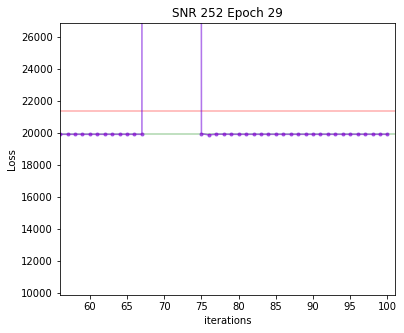

In [17]:
plt_i = 29
mdl_i = 0

plt.figure(figsize=(6,5))
for j in range(len(init_vels)):
    iter_num = [xl.nfev for xl in models[j][mdl_i].results]
    print(iter_num)
    print(len(models[j][mdl_i].history))

    models[j][mdl_i].fix()
    models[j][mdl_i].fit(1)
    loss_check = []
    for i,params in enumerate(models[j][mdl_i].history):
        if i > iter_num[0]-1:
            models[j][mdl_i].fit(0)
        loss_check.append(loss(params,datasets[mdl_i],plt_i,models[j][mdl_i]).sum())

    models[j][mdl_i].fix()
    a = models[j][mdl_i][0].p
    fix_loss = loss([],datasets[mdl_i],plt_i,models[j][mdl_i]).sum()

    
    models[j][mdl_i].fit(0)
    b = models[j][mdl_i].get_parameters()
    fitting_loss = loss(b,datasets[mdl_i],plt_i,models[j][mdl_i]).sum()
#     print(a == b)


    loss_total = [xl[plt_i,:].sum() for xl in models[j][mdl_i].loss_history]

    print(fitting_loss, fix_loss, min(loss_total), loss_total[-1], np.argmin(loss_total))
    alpha = 0.08*(j+1)
    plt.plot(loss_total,'.-b',alpha=alpha,label='func evals')
    plt.plot(loss_check,'.-m',alpha=alpha,label='func check')
    
    plt.hlines(fix_loss,0,len(models[j][mdl_i].func_evals),['g'],label='fix loss',alpha=alpha)
    plt.hlines(fitting_loss,0,len(models[j][mdl_i].func_evals),['r'],label='fit loss',alpha=alpha)
plt.ylim(min(loss_total)-1e4,min(loss_total)+0.7e4)
# print(min(loss_total))
plt.xlim(len(models[-1][mdl_i].func_evals) - 45, len(models[-1][mdl_i].func_evals))
plt.title('SNR {:2.0f} Epoch {}'.format(snrs[mdl_i], plt_i))
plt.ylabel('Loss')
plt.xlabel('iterations')
# plt.legend()
plt.show()

In [18]:
import cProfile

In [19]:
# cProfile.run("loss(b,datasets[0],0,models[0]).sum()")

In [20]:
fig = plt.figure(figsize=(10,4),facecolor=(1,1,1))
v_unit = u.m/u.s
plt.plot((rv - init_vels).to(v_unit).value,'Dk',label='truth')
for i in range(len(datasets)):
    for j in range(len(init_vels)):
    
        vmean  = np.mean(final_vels[i,:])
        v_unit = u.m/u.s
        plt.plot((final_vels[i,:] - vmean - init_vels).to(v_unit).value,'o',label='snr {:2.1f} init {}'.format(snrs[i],j),c=cm.plasma(snrs[i]/max(snrs)),alpha=0.1*j,markersize=10*(snrs[i]/max(snrs))**(1/2))
plt.ylabel('vel [{}]'.format(v_unit))
plt.xlabel('epoch')
plt.legend()
plt.savefig(os.path.join(outdir,'rvs_s_min_init.png'),dpi=300)
plt.show()

UnitConversionError: Can only apply 'subtract' function to dimensionless quantities when other argument is not a quantity (unless the latter is all zero/infinity/nan)

<Figure size 720x288 with 0 Axes>

In [21]:
import itertools

In [22]:
print(jabble.dataset.shifts(3 * u.km/u.s)/(x_grid[1] - x_grid[0]),jabble.dataset.shifts(3 * u.km/u.s),x_grid[1] - x_grid[0])

2.6017999420676827 1.0006922856216254e-05 3.846153846964739e-06


316.7037582371806 m / s
202.59153935966248 m / s
108.80498846319784 m / s
0.00387112092593119 m / s


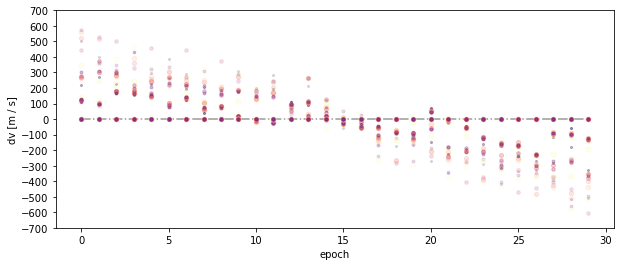

In [24]:
fig,ax = plt.subplots(1,figsize=(10,4),facecolor=(1,1,1))
v_unit = u.m/u.s

plt.plot(np.zeros((30)),'-.k',alpha=0.4)
# fig.colorbar(cm.plasma)
v_unit = u.m/u.s

marker = itertools.cycle(('+', '.', 'o', '*')) 
# for n in y:
#     plt.plot(x,n, marker = next(marker), linestyle='')

for j in range(len(init_vels)):
    alpha = 0.15*(j+1)
    vstd = np.std(np.concatenate([jabble.dataset.velocities(models[j][xy][0].p  - jabble.dataset.shifts(rv)) for xy in range(len(datasets))]))
#     ax.hlines([-vstd.to(v_unit).value,vstd.to(v_unit).value],0,epoches,
#                    'k',alpha=[alpha for xy in range(2)])
    print(vstd)
    for i in range(len(datasets)):
        vels = jabble.dataset.velocities(models[j][i][0].p - jabble.dataset.shifts(rv))
        vmean  = np.mean(vels)
        vstd   = np.std(vels)
#         alpha = 0.15*(j+1)

#         plt.hlines([-vstd.to(v_unit).value,vstd.to(v_unit).value],0,len(vels),
#                    colors=[cm.magma(snrs[i]/max(snrs)) for xy in range(2)],alpha=[alpha for xy in range(2)])
        plt.plot( (vels - vmean).to(v_unit).value,'.',label='snr {:2.1f} init {}'.format(snrs[i],j),
                 c=cm.magma(snrs[i]/max(snrs)),alpha=alpha,markersize=10 * (snrs[i]/max(snrs))**(1/2))

# for i in range(len(datasets)):
#     vstd = np.std(np.concatenate([jabble.dataset.velocities(models[xy][i][0].p) - rv for xy in range(len(init_vels))]))
#     plt.hlines([-vstd.to(v_unit).value,vstd.to(v_unit).value],0,epoches,
#                  colors=[cm.magma(snrs[i]/max(snrs)) for xy in range(2)],alpha=0.4)


vel_ticks = np.arange(-700,710,step=100)
ax.set_yticks(vel_ticks)

# step_ax = ax.twinx()
# step_tick = jabble.dataset.shifts(vel_ticks*u.m/u.s)
# print(step_tick)
# step_ax.set_yticks(vel_ticks)
# step_ax.set_yticklabels(['{:2.1e}'.format(xy/(x_grid[1] - x_grid[0])) for xy in step_tick])
# step_ax.set_ylabel('$\Delta ln \lambda$')
    
# avg_inits = [np.mean()]
ax.set_ylabel('dv [{}]'.format(v_unit))
plt.xlabel('epoch')
# ax.set_ylim(-250,250)
# plt.legend()
plt.savefig(os.path.join(outdir,'rvs_s_min_rvs.png'),dpi=300)
plt.show()

In [25]:
outdir

'/scratch/mdd423/wobble_jax/out/2022-06-06'

this means we are more limited by starting position than by the SNR

<h2>Plotting Hours</h2>
Oh yea it's plottin' time

In [ ]:
# %matplotlib notebook

In [ ]:
models[0].fix()
models[0].fit(0)
b = models[0].get_parameters()
print(b.shape)

In [ ]:
plt_i = 12
mdl_i = 0

iter_num = [xl.nfev for xl in models[mdl_i].results]
print(iter_num)
print(len(models[mdl_i].history))

models[mdl_i].fix()
models[mdl_i].fit(1)
loss_check = []
for i,params in enumerate(models[mdl_i].history):
    if i > iter_num[0]-1:
        models[mdl_i].fit(0)
    loss_check.append(loss(params,datasets[mdl_i],plt_i,models[mdl_i]).sum())

models[mdl_i].fix()
a = models[mdl_i][0].p
fix_loss = loss([],datasets[mdl_i],plt_i,models[mdl_i]).sum()

print(a == b)
models[mdl_i].fit(0)
b = models[mdl_i].get_parameters()
fitting_loss = loss(b,datasets[mdl_i],plt_i,models[mdl_i]).sum()

plt.figure(figsize=(6,5))

loss_total = [xl[plt_i,:].sum() for xl in models[mdl_i].loss_history]

print(fitting_loss, fix_loss, min(loss_total), loss_total[-1], np.argmin(loss_total))

plt.plot(loss_total,'.-b',alpha=0.3,label='func evals')
plt.plot(loss_check,'.-m',alpha=0.3,label='func check')

plt.hlines(fix_loss,0,len(models[mdl_i].func_evals),['g'],label='fix loss')
plt.hlines(fitting_loss,0,len(models[mdl_i].func_evals),['r'],label='fit loss')
# plt.ylim(min(loss_total)-1e3,min(loss_total)+1e3)
print(min(loss_total))
# plt.xlim(len(models[mdl_i].func_evals) - 40, len(models[mdl_i].func_evals))
plt.title('SNR {:2.0f} Epoch {}'.format(snrs[mdl_i], plt_i))
plt.ylabel('Loss')
plt.xlabel('iterations')
plt.legend()
plt.show()

In [ ]:
plt_i = 2
xpmin = np.log(7274.5)
xpmax = np.log(7276.5)
fig, axes = plt.subplots(len(datasets),figsize=(5,5),sharex=True,sharey=True,facecolor=(1,1,1))

tick_min = np.min(datasets[0].xs[0,:])
tick_max = np.max(datasets[0].xs[0,:])
tick_length = 0.5
xlabels = np.arange(tick_length * round(np.exp(tick_min)/tick_length),tick_length * round(np.exp(tick_max)/tick_length),step=tick_length)
xtxpos  = np.log(xlabels)
plt.xticks(xtxpos,xlabels)
plt.xlabel('Wavelength [ A ]')

plot_shift = 0.8

fig.suptitle('RV {:2.1f}'.format(rv[plt_i]))
indices = np.argsort(snrs)
for index,i in enumerate(indices):
#     i = index
    axes[index].step(np.log(h5_data[i]['theory']['interpolated']['total']['wave'].to(u.Angstrom).value),np.log(normal_flux(h5_data[i]['theory']['interpolated']['star']['flux'][plt_i,:]))+ 2 * plot_shift,'r',where='mid',alpha=0.5,label='stellar theory')
    axes[index].step(np.log(h5_data[i]['theory']['interpolated']['total']['wave'].to(u.Angstrom).value),np.log(h5_data[i]['theory']['interpolated']['random']['flux'][plt_i,:]) + 1. * plot_shift,'b',where='mid',alpha=0.5,label='tellurics theory')
    axes[index].step(datasets[i].xs[plt_i,:],datasets[i].ys[plt_i,:],'k',where='mid',label='data')
    axes[index].plot(models[i][1].xs-models[i][0].p[plt_i],models[i][1].p + 3 * plot_shift,'.r',zorder=2,alpha=0.5,ms=6,label='stellar model')
    axes[index].set_xlim(xpmin,xpmax)
    axes[index].set_ylim(-0.8,3.)
    axes[index].set_ylabel('snr {:2.1f}'.format(snrs[i]))
    
    
    res_ax = axes[index].twinx()
#     residual = ((datasets[i].ys[plt_i,:] - models[i](models[i].get_parameters(),datasets[i].xs[plt_i,:],i))) * np.sqrt(datasets[i].yivar[plt_i,:])
#     res_ax.step(datasets[i].xs[plt_i,:],residual,where='mid',alpha=0.3,label='residual')
    models[i].fit(0)
    b = models[i].get_parameters()
    res_ax.step(datasets[i].xs[plt_i,:],loss(b,datasets[i],0,models[i]),'blue',where='mid',alpha=0.3,label='residual')
    print(loss(b,datasets[i],0,models[i]).sum())
    models[i].fix()
    a = models[i][0].p
    print(loss([],datasets[i],0,models[i]).sum())
    res_ax.step(datasets[i].xs[plt_i,:],loss([],datasets[i],0,models[i]),'green',where='mid',alpha=0.3,label='residual')
#     res_ax.step(datasets[i].xs[plt_i,:],models[i].loss_history[-2][plt_i,:],'red',where='mid',alpha=0.3,label='residual')
    
    
    res_ax.set_xlim(xpmin,xpmax)
    res_ax.set_ylim(-1.5e2,1.5e2)
handles, labels = axes[0].get_legend_handles_labels()
res_handles, res_labels = res_ax.get_legend_handles_labels()
for i,hand in enumerate(res_handles):
    handles.append(hand)
    labels.append(res_labels[i])
# fig.legend(handles, labels)
plt.savefig(os.path.join(outdir,'flux_s_snrs_x{:2.1f}-{:2.1f}.png'.format(xpmin,xpmax)),dpi=300)
plt.show()

In [ ]:
# plt_inds = 4
# xpmin = np.log(7575)
# xpmax = np.log(7580)
# fig, axes = plt.subplots(plt_inds,figsize=(10,10),sharex=True,sharey=True,facecolor=(1,1,1))

# dataset_i = 1
# fig.suptitle('SNR {:2.1f}'.format(snrs[dataset_i]))
# for j in range(plt_inds):        
#     axes[j].step(np.log(h5_data[dataset_i]['theory']['interpolated']['total']['wave'].to(u.Angstrom).value),np.log(normal_flux(h5_data[dataset_i]['theory']['interpolated']['star']['flux'][j,:])),'r',where='mid',alpha=0.5,label='stellar theory')
#     axes[j].step(np.log(h5_data[dataset_i]['theory']['interpolated']['total']['wave'].to(u.Angstrom).value),np.log(h5_data[dataset_i]['theory']['interpolated']['random']['flux'][j,:]) + 3.,'b',where='mid',alpha=0.5,label='tellurics theory')
#     axes[j].step(datasets[dataset_i].xs[j,:],datasets[i].ys[j,:] + 1.,'k',where='mid',label='data')
#     axes[j].plot(models[dataset_i][1].xs-models[dataset_i][0].p[j] + 2.,models[dataset_i][1].p,'.r',zorder=2,alpha=0.5,ms=6,label='stellar model')
    
#     axes[j].set_xlim(xpmin,xpmax)
#     axes[j].set_ylim(-1.2,5)
#     axes[j].set_ylabel('RV {:1.0f}'.format(rv[j]))
    
#     res_ax = axes[j].twinx()
# #     residual = ((datasets[i].ys[plt_i,:] - models[i](models[i].get_parameters(),datasets[i].xs[plt_i,:],i))) * np.sqrt(datasets[i].yivar[plt_i,:])
#     res_ax.step(datasets[dataset_i].xs[j,:],residual,where='mid',alpha=0.2,label='residual')
#     res_ax.set_xlim(xpmin,xpmax)
#     res_ax.set_ylim(-1e2,1e2)
# handles, labels = axes[0].get_legend_handles_labels()
# res_handles, res_labels = res_ax.get_legend_handles_labels()
# handles.append(*res_handles)
# labels.append(*res_labels)
# fig.legend(handles, labels)
    
# plt.savefig(os.path.join(outdir,'flux_s_rvs_x{:2.1f}-{:2.1f}.png'.format(xpmin,xpmax)),dpi=300)
# plt.show() 

In [ ]:
for i in range(len(datasets)):
#     print(jabble.dataset.velocities(models[i][0].p)[0])''
    if i >0:
        print(id(models[i][0].p) == id(models[i-1][0].p))

In [ ]:
fig = plt.figure(figsize=(10,4),facecolor=(1,1,1))
v_unit = u.m/u.s
plt.plot((rv - init_vels).to(v_unit).value,'dk',label='truth')
# plt.plot((init_vels-init_vels).to(v_unit).value,'og',label='init')

# fig.colorbar(cm.plasma)
for i in range(len(datasets)):
    final_vels = jabble.dataset.velocities(models[i][0].p)
    
    v_unit = u.m/u.s
    plt.plot((final_vels - init_vels).to(v_unit).value,'o',label='snr {:2.1f}'.format(snrs[i]),c=cm.plasma(snrs[i]/max(snrs)),alpha=0.8)
    plt.ylabel('vel [{}]'.format(v_unit))
    plt.xlabel('epoch')
plt.legend()
plt.savefig(os.path.join(outdir,'rvs_s_min_init.png'),dpi=300)
plt.show()

In [ ]:
# fig = plt.figure(figsize=(10,4),facecolor=(1,1,1))
# v_unit = u.m/u.s

# # fig.colorbar(cm.plasma)
# for i in range(len(datasets)):
# #     final_vels = jabble.dataset.velocities(models[i][0].p)
#     print(final_vels[0])
#     v_unit = u.m/u.s
#     plt.plot((final_vels - rv).to(v_unit).value,'.',label='snr {:2.1f}'.format(snrs[i]),c=cm.plasma(snrs[i]/max(snrs)),alpha=0.8,markersize=20*(snrs[i]/max(snrs)))
#     plt.ylabel('dv [{}]'.format(v_unit))
#     plt.xlabel('epoch')
# plt.legend()
# plt.savefig(os.path.join(outdir,'rvs_s_min_rvs.png'),dpi=300)
# plt.show()

In [ ]:
# fig = plt.figure(figsize=(10,4))
# v_unit = u.m/u.s
# # plt.plot((rv - init_vels).to(v_unit).value,'ok',label='truth')
# # plt.plot((init_vels-init_vels).to(v_unit).value,'og',label='truth')

# # fig.colorbar(cm.plasma)
# for i in range(len(datasets)):
#     final_vels = jabble.dataset.velocities(models[i][0].p)
    
#     v_unit = u.m/u.s
#     plt.plot(abs((final_vels - rv)/rv),'.',label='snr {:2.1f}'.format(snrs[i]),c=cm.plasma(snrs[i]/max(snrs)),alpha=0.8)
#     plt.ylabel('frac res'.format(v_unit))
#     plt.xlabel('epoch')
# plt.legend()
# # plt.savefig(os.path.join(outdir,'rvs_s_min_init.png'))
# plt.show()

In [ ]:
for model in models:
    print(model.results)

In [ ]:
import cv2

In [ ]:
def sliding_video(datasets,models,snrs,h5_data,padding,frames,filename,file_format='XVID',fps=24,velocity=1,tick_length = 2.,start_wavelength=None):
    import cv2 as cv
    import matplotlib.pyplot as plt
    import time
    import datetime
    
    fig, axes = plt.subplots(len(datasets),figsize=(10,10),sharex=True,sharey=True,facecolor=(1,1,1))
    
    
    plot_shift = 0.8

    fig.suptitle('RV {:2.1f}'.format(rv[plt_i]))
    indices = np.argsort(snrs).astype(int)
    snrs = [snrs[i] for i in indices]
    datasets = [datasets[i] for i in indices]
    h5_data = [h5_data[i] for i in indices]
    models = [models[i] for i in indices]
    lines = {}
    
     # Angstroms
    
        
    tick_min = np.min(datasets[0].xs[0,:])
    tick_max = np.max(datasets[0].xs[0,:])
    if start_wavelength is None:
        plot_min = tick_min
    else:
        plot_min = np.log(start_wavelength)
    xlabels = np.arange(tick_length * round(np.exp(tick_min)/tick_length),tick_length * round(np.exp(tick_max)/tick_length),step=tick_length)
    xtxpos  = np.log(xlabels)
    plt.xticks(xtxpos,xlabels)
    plt.yticks([])
    plt.xlabel('Wavelength [ A ]')
    residuals = []
    for i in range(len(datasets)):
        key = 'snr {:2.1f}'.format(snrs[i])
        max_val = plot_min + padding
        min_val = plot_min - padding
        lines[key] = {}
        mask_the = (np.log(h5_data[i]['theory']['interpolated']['total']['wave'].to(u.Angstrom).value < max_val))
        mask_the = mask_the.astype(bool)
        lines[key]['star'] = axes[i].step(np.log(h5_data[i]['theory']['interpolated']['total']['wave'].to(u.Angstrom).value[mask_the]),np.log(normal_flux(h5_data[i]['theory']['interpolated']['star']['flux'][plt_i,:]))[mask_the]+ 2 * plot_shift,'r',where='mid',alpha=0.5,label='stellar theory')[0]
        lines[key]['tellurics'] = axes[i].step(np.log(h5_data[i]['theory']['interpolated']['total']['wave'].to(u.Angstrom).value[mask_the]),np.log(h5_data[i]['theory']['interpolated']['random']['flux'][plt_i,:])[mask_the] + 1. * plot_shift,'b',where='mid',alpha=0.5,label='tellurics theory')[0]
        mask_data = (datasets[i].xs[plt_i,:] < max_val)
        mask_data = mask_data.astype(bool)
        lines[key]['data'] = axes[i].step(datasets[i].xs[plt_i,mask_data],datasets[i].ys[plt_i,mask_data],'k',where='mid',label='data')[0]
        mask_model = (models[i][1].xs-models[i][0].p[plt_i] < max_val)
        mask_model = mask_model.astype(bool)
        lines[key]['model'] = axes[i].plot((models[i][1].xs-models[i][0].p[plt_i])[mask_model],models[i][1].p[mask_model] + 3 * plot_shift,'.r',zorder=2,alpha=0.5,ms=6,label='stellar model')[0]
        axes[i].set_xlim(min_val,max_val)
        axes[i].set_ylim(-0.8,3.)
        axes[i].set_ylabel('snr {:2.1f}'.format(snrs[i]))

        res_ax = axes[i].twinx()
        residual = ((datasets[i].ys[plt_i,:] - models[i](models[i].get_parameters(),datasets[i].xs[plt_i,:],i))) * np.sqrt(datasets[i].yivar[plt_i,:])
        residuals.append(residual)
        lines[key]['residual'] = res_ax.step(datasets[i].xs[plt_i,mask_data],residual[mask_data],where='mid',alpha=0.3,label='residual')[0]
        res_ax.set_xlim(min_val,max_val)
        res_ax.set_ylim(-1e2,1e2)
    handles, labels = axes[0].get_legend_handles_labels()
    res_handles, res_labels = res_ax.get_legend_handles_labels()
    handles.append(*res_handles)
    labels.append(*res_labels)
    fig.legend(handles, labels)

    
    ############################
    
    shape = fig.canvas.get_width_height()[::-1]
#     print(shape)
    fourcc = cv.VideoWriter_fourcc(*file_format)
    video = cv.VideoWriter(filename,fourcc,fps=fps,\
                            frameSize=(shape[0],shape[1]))

    
    vel_x = velocity / plot_min
    dx = vel_x/fps
    
    print("saving...")
    dt_avg = 0.0
    est_time = 0.0
    for j in range(frames):
        print('[ {} / {} ] - {}'.format(j,frames,str(datetime.timedelta(seconds=est_time))))
        # REDRAW ALL LINES
        time_start = time.time()
        for i,key in enumerate(lines.keys()):
            max_val = (dx*j) + padding + plot_min
            min_val = (dx*j) - padding + plot_min
            mask_the = (np.log(h5_data[i]['theory']['interpolated']['total']['wave'].to(u.Angstrom).value) < max_val) * (np.log(h5_data[i]['theory']['interpolated']['total']['wave'].to(u.Angstrom).value) > min_val)
            mask_the = mask_the.astype(bool)
            lines[key]['star'].set_xdata(np.log(h5_data[i]['theory']['interpolated']['total']['wave'].to(u.Angstrom).value[mask_the]))
            lines[key]['star'].set_ydata(np.log(normal_flux(h5_data[i]['theory']['interpolated']['star']['flux'][plt_i,:]))[mask_the] + 2 * plot_shift)

            lines[key]['tellurics'].set_xdata(np.log(h5_data[i]['theory']['interpolated']['total']['wave'].to(u.Angstrom).value[mask_the]))
            lines[key]['tellurics'].set_ydata(np.log(h5_data[i]['theory']['interpolated']['random']['flux'][plt_i,:])[mask_the] + 1. * plot_shift)
             
            
            mask_data = (datasets[i].xs[plt_i,:] < max_val) * (datasets[i].xs[plt_i,:] > min_val)
            mask_data = mask_data.astype(bool)
            lines[key]['data'].set_xdata(datasets[i].xs[plt_i,mask_data])
            lines[key]['data'].set_ydata(datasets[i].ys[plt_i,mask_data])
            # mask model
            mask_model = (models[i][1].xs-models[i][0].p[plt_i] < max_val) * (models[i][1].xs-models[i][0].p[plt_i] > min_val)
            mask_model = mask_model.astype(bool)
            lines[key]['model'].set_xdata((models[i][1].xs-models[i][0].p[plt_i])[mask_model])
            lines[key]['model'].set_ydata(models[i][1].p[mask_model] + 3 * plot_shift)
            axes[i].set_xlim(min_val,max_val)

            lines[key]['residual'].set_xdata(datasets[i].xs[plt_i,mask_data])
            lines[key]['residual'].set_ydata(residuals[i][mask_data])
            res_ax.set_xlim(min_val,max_val)                        
                          
        ###############################################

        # redraw the canvas
        fig.canvas.draw()

        # convert canvas to image
        img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))

        # img is rgb, convert to opencv's default bgr
        img = cv.cvtColor(img,cv.COLOR_RGB2BGR)
    
        time_end = time.time()
        dt = time_end - time_start
        dt_avg *= j/(j+1)
        dt_avg += dt / (j+1)
        est_time = dt_avg * (frames-j-1)
        video.write(img)

    cv.destroyAllWindows()
    video.release()
    print("saved to {}".format(filename))

In [ ]:
start_wavelength = np.exp(np.min(models[0][1].xs))
velocity = 0.0009
frames = 120
fps = 24
start_wavelength = 7010
padding = np.log(8104)-np.log(8100)
filename = os.path.join(outdir,'wobble_vid_fps{:2.0f}_w{:2.1f}_v{:2.0f}_pd{:2.1f}.mp4'.format(fps,start_wavelength,velocity,padding))
sliding_video(datasets,models,snrs,h5_data,padding,frames=frames,filename=filename,file_format='MP4V',fps=fps,velocity=velocity,start_wavelength=start_wavelength)

In [ ]:
print(filename)

In [ ]:
Video(filename,width=720,embed=True)